In [3]:
import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from dask_ml.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [18]:
DATASET_PATH = "./data/Chicago_Crimes.parquet"

if not os.path.exists("./data"):
    os.makedirs("./data")

if not os.path.exists(DATASET_PATH):
    df = pd.read_csv("Crimes.csv")
    ddf = dd.from_pandas(df, npartitions=10)
    ddf.to_parquet(DATASET_PATH)
else:
    ddf = dd.read_parquet(DATASET_PATH)

In [19]:
print(ddf.head())

         ID Case Number                    Date                   Block  IUCR  \
0  11646166    JC213529  09/01/2018 12:01:00 AM   082XX S INGLESIDE AVE  0810   
1  11645836    JC212333  05/01/2016 12:25:00 AM     055XX S ROCKWELL ST  1153   
2  11449702    JB373031  07/31/2018 01:30:00 PM  009XX E HYDE PARK BLVD  2024   
3  11643334    JC209972  12/19/2018 04:30:00 PM  056XX W WELLINGTON AVE  1320   
4  11645527    JC212744  02/02/2015 10:00:00 AM      069XX W ARCHER AVE  1153   

         Primary Type                          Description  \
0               THEFT                            OVER $500   
1  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
2           NARCOTICS                  POSS: HEROIN(WHITE)   
3     CRIMINAL DAMAGE                           TO VEHICLE   
4  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   

  Location Description  Arrest  Domestic  ...  Ward  Community Area  FBI Code  \
0            RESIDENCE   False      True  ...   8.0        

In [20]:
def missing_values_table(df):
    missing_values = df.isnull().sum().compute()
    missing_percent = (missing_values / len(df)) * 100
    missing_data = pd.DataFrame({"Missing Values": missing_values, "Percent": missing_percent})
    return missing_data[missing_data["Missing Values"] > 0]

print(missing_values_table(ddf))

                      Missing Values   Percent
Case Number                        4  0.000051
Location Description           10758  0.137100
District                          47  0.000599
Ward                          614849  7.835657
Community Area                613476  7.818159
X Coordinate                   88111  1.122890
Y Coordinate                   88111  1.122890
Latitude                       88111  1.122890
Longitude                      88111  1.122890
Location                       88111  1.122890


In [21]:
columns_to_keep = ["Primary Type", "Latitude", "Longitude", "Date"]
ddf = ddf.dropna(subset=columns_to_keep)

In [23]:
ddf['Date'] = dd.to_datetime(ddf['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
ddf = ddf.dropna(subset=['Date'])
ddf['Hour'] = ddf['Date'].dt.hour

In [24]:
label_encoder = LabelEncoder()
ddf["Primary Type Encoded"] = ddf["Primary Type"].map(lambda x: label_encoder.fit_transform([x])[0])
os.makedirs("./models", exist_ok=True)
joblib.dump(label_encoder, "./models/label_encoder.pkl")

['./models/label_encoder.pkl']

In [25]:
X = ddf[["Latitude", "Longitude", "Hour"]]
y = ddf["Primary Type Encoded"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Natalia\anaconda\Lib\site-packages\dask_ml\model_selection\_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.compute())
X_test_scaled = scaler.transform(X_test.compute())
joblib.dump(scaler, "./models/scaler.pkl")

['./models/scaler.pkl']

In [28]:
model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric="mlogloss")
model.fit(X_train_scaled, y_train.compute())

C:\Users\Natalia\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:20:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [29]:
joblib.dump(model, "./models/crime_model.pkl")

['./models/crime_model.pkl']

In [30]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test.compute(), y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1551224

    accuracy                           1.00   1551224
   macro avg       1.00      1.00      1.00   1551224
weighted avg       1.00      1.00      1.00   1551224



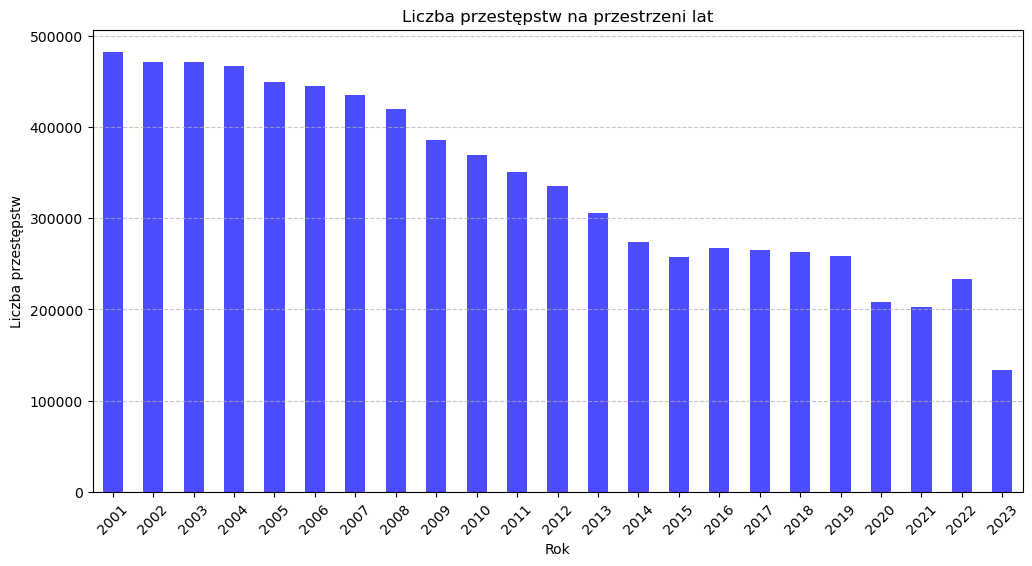

In [32]:
ddf['Year'] = ddf['Date'].dt.year
crime_per_year = ddf.groupby('Year').size().compute()

plt.figure(figsize=(12, 6))
crime_per_year.plot(kind='bar', color='blue', alpha=0.7)
plt.title("Liczba przestępstw na przestrzeni lat")
plt.xlabel("Rok")
plt.ylabel("Liczba przestępstw")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

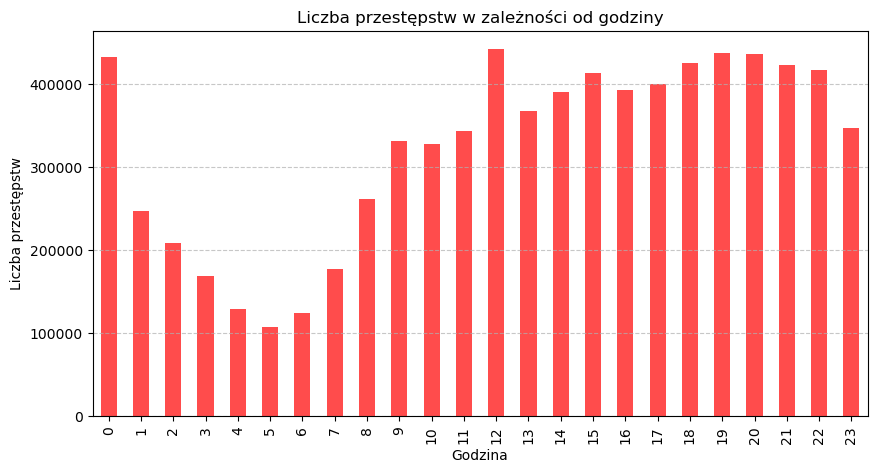

In [33]:
crime_per_hour = ddf.groupby('Hour').size().compute()

plt.figure(figsize=(10, 5))
crime_per_hour.plot(kind='bar', color='red', alpha=0.7)
plt.title("Liczba przestępstw w zależności od godziny")
plt.xlabel("Godzina")
plt.ylabel("Liczba przestępstw")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

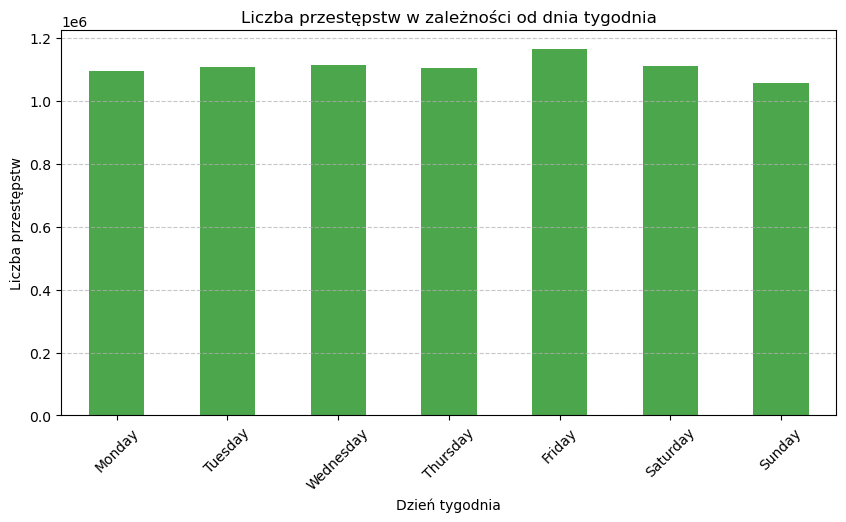

In [35]:
ddf['DayOfWeek'] = ddf['Date'].dt.day_name()
crime_per_day = ddf.groupby('DayOfWeek').size().compute()

plt.figure(figsize=(10, 5))
crime_per_day.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(kind='bar', color='green', alpha=0.7)
plt.title("Liczba przestępstw w zależności od dnia tygodnia")
plt.xlabel("Dzień tygodnia")
plt.ylabel("Liczba przestępstw")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

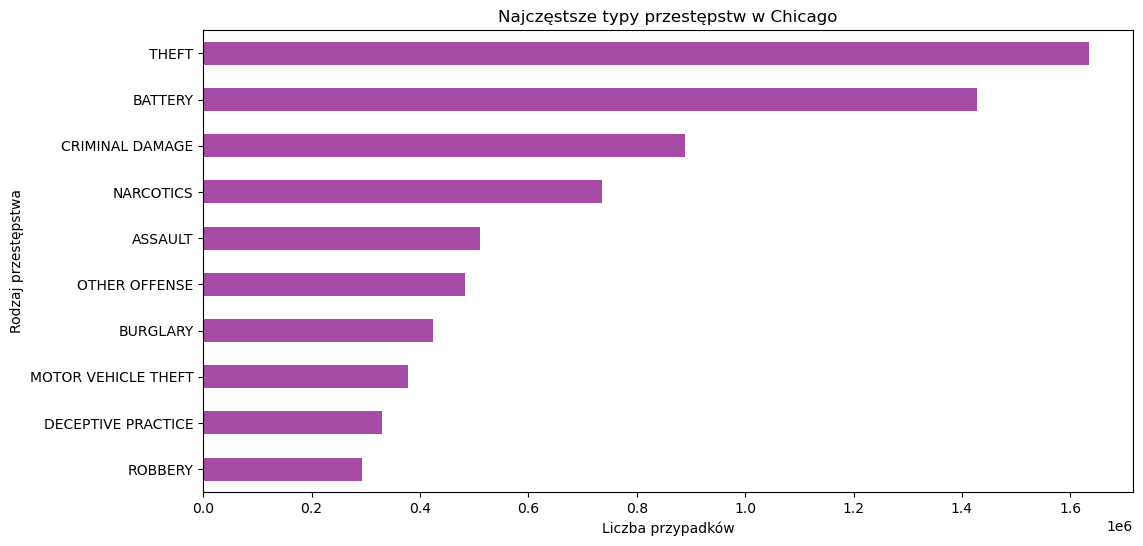

In [34]:
crime_type_counts = ddf['Primary Type'].value_counts().nlargest(10).compute()

plt.figure(figsize=(12, 6))
crime_type_counts.plot(kind='barh', color='purple', alpha=0.7)
plt.title("Najczęstsze typy przestępstw w Chicago")
plt.xlabel("Liczba przypadków")
plt.ylabel("Rodzaj przestępstwa")
plt.gca().invert_yaxis()
plt.show()